# Data Analysis and Logistic Regression with Customer Profiles

This notebook loads data directly from CSV files, integrates customer profiles from clustering analysis, and performs logistic regression to predict customer response behavior.

In [12]:
# Load all datasets directly from CSV files
import pandas as pd
import numpy as np

# Load contact history fact data
contact_history_raw = pd.read_csv('data/Contact_History_Fact_0.csv')
print(f"Loaded contact history data: {contact_history_raw.shape}")

# Load customer profiles mapping (generated from customers.ipynb)
customer_profiles = pd.read_csv('data/customer_profiles_mapping.csv')
print(f"Loaded customer profiles mapping: {customer_profiles.shape}")

# Load all related datasets
customer_score_raw = pd.read_csv('data/Customer_Score_0_RV.csv')
print(f"Loaded customer score data: {customer_score_raw.shape}")

campaign_raw = pd.read_csv('data/CH_Campaign_0_V.csv')
print(f"Loaded campaign data: {campaign_raw.shape}")

cell_raw = pd.read_csv('data/CH_Cell_0_V.csv')
print(f"Loaded cell data: {cell_raw.shape}")

offer_raw = pd.read_csv('data/CH_Offer_0_V.csv')
print(f"Loaded offer data: {offer_raw.shape}")

customer_fact_raw = pd.read_csv('data/Customer_Fact_0_V.csv')
print(f"Loaded customer fact data: {customer_fact_raw.shape}")

print("\nContact History Data Columns:")
print(contact_history_raw.columns.tolist())

print("\nCustomer Profiles Columns:")
print(customer_profiles.columns.tolist())

# Find columns ending with "key"
key_columns = [col for col in contact_history_raw.columns if col.endswith('key')]
print(f"\nColumns ending with 'key': {key_columns}")

print("\nFirst few rows of contact history data:")
print(contact_history_raw.head())

print("\nFirst few rows of customer profiles:")
print(customer_profiles.head())

Loaded contact history data: (1527978, 9)
Loaded customer profiles mapping: (190339, 2)
Loaded customer score data: (1047507, 25)
Loaded campaign data: (55, 7)
Loaded cell data: (17249, 11)
Loaded offer data: (19699, 5)
Loaded customer fact data: (1047507, 39)

Contact History Data Columns:
['date_key', 'customer_key', 'customer_score_key', 'ch_campaign_key', 'ch_cell_key', 'ch_offer_key', 'cch_responder_key', 'offer_amount_loc_currency', 'volume']

Customer Profiles Columns:
['customer_key', 'profile_name']

Columns ending with 'key': ['date_key', 'customer_key', 'customer_score_key', 'ch_campaign_key', 'ch_cell_key', 'ch_offer_key', 'cch_responder_key']

First few rows of contact history data:
              date_key  customer_key  customer_score_key  ch_campaign_key  \
0  2018-01-31 00:00:00       5973888           343229725             3671   
1  2018-02-28 00:00:00       2458586           345294541             4115   
2  2018-02-28 00:00:00       6365820           343707868        

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Available datasets for merging:")
print(f"Customer profiles: {customer_profiles.shape}")
print(f"Customer score data: {customer_score_raw.shape}")
print(f"Campaign data: {campaign_raw.shape}")
print(f"Cell data: {cell_raw.shape}")
print(f"Offer data: {offer_raw.shape}")
print(f"Customer fact data: {customer_fact_raw.shape}")

# Check the key columns in each dataset
print("\nCustomer profiles columns:", customer_profiles.columns.tolist())
print("Customer score data columns:", customer_score_raw.columns.tolist())
print("Campaign data columns:", campaign_raw.columns.tolist())
print("Cell data columns:", cell_raw.columns.tolist())
print("Offer data columns:", offer_raw.columns.tolist())
print("Customer fact data columns:", customer_fact_raw.columns.tolist())

# Start with the contact history data
merged_data = contact_history_raw.copy()
print(f"\nStarting with contact history data: {merged_data.shape}")

# Merge with customer profiles on customer_key (instead of raw customer data)
merged_data = merged_data.merge(customer_profiles, on='customer_key', how='left')
print(f"After merging with customer profiles: {merged_data.shape}")

# Merge with customer score data on customer_score_key
merged_data = merged_data.merge(customer_score_raw, on='customer_score_key', how='left')
print(f"After merging with customer score data: {merged_data.shape}")

# Merge with campaign data on ch_campaign_key
merged_data = merged_data.merge(campaign_raw, on='ch_campaign_key', how='left')
print(f"After merging with campaign data: {merged_data.shape}")

# Merge with cell data on ch_cell_key
merged_data = merged_data.merge(cell_raw, on='ch_cell_key', how='left')
print(f"After merging with cell data: {merged_data.shape}")

# Merge with offer data on ch_offer_key
merged_data = merged_data.merge(offer_raw, on='ch_offer_key', how='left')
print(f"After merging with offer data: {merged_data.shape}")

print(f"\nFinal merged dataset shape: {merged_data.shape}")
print(f"Target variable (cch_responder_key) distribution:")
print(merged_data['cch_responder_key'].value_counts())

print(f"\nCustomer profile distribution in merged data:")
print(merged_data['profile_name'].value_counts())

Available datasets for merging:
Customer profiles: (190339, 2)
Customer score data: (1047507, 25)
Campaign data: (55, 7)
Cell data: (17249, 11)
Offer data: (19699, 5)
Customer fact data: (1047507, 39)

Customer profiles columns: ['customer_key', 'profile_name']
Customer score data columns: ['customer_score_key', 'TIBScore', 'FrequencyDecile', 'RecencyDecile', 'TotalIncomeDecile', 'TotalRetBalanceDecile', 'ATMChannelFlag', 'BranchChannelFlag', 'ITBChannelFlag', 'POSChannelFlag', 'TSChannelFlag', 'Age', 'NumProducts', 'ValidGenderFlag', 'OnlineRegFlag', 'OnlineActiveFlagW', 'OnlineActiveFlagM', 'num_atm_trans', 'num_branch_trans', 'num_online_trans', 'num_ivr_trans', 'num_pos_trans', 'PayrollFlag', 'num_ITB_bill_paymts_trans', 'num_offline_bill_pmt_tran']
Campaign data columns: ['ch_campaign_key', 'campaign_code', 'campaign_start_date', 'campaign_expiry_date', 'campaign_id', 'campaign_label', 'campaign_type']
Cell data columns: ['ch_cell_key', 'channel1', 'channel2', 'channel3', 'channel

In [20]:
# Prepare features and target for logistic regression
# Remove key columns that won't be used as features and the target
key_columns = ['date_key', 'customer_key', 'customer_score_key', 'ch_campaign_key',
               'ch_cell_key', 'ch_offer_key', 'cch_responder_key']

# Select feature columns (exclude keys and target)
feature_columns = [col for col in merged_data.columns if col not in key_columns]
print(f"Feature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns):
    print(f"{i+1:2d}. {col}")

# Prepare X (features) and y (target)
X = merged_data[feature_columns].copy()
y = merged_data['cch_responder_key'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Check for missing values
print(f"\nMissing values per column:")
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])

Feature columns (47):
 1. offer_amount_loc_currency
 2. volume
 3. profile_name
 4. TIBScore
 5. FrequencyDecile
 6. RecencyDecile
 7. TotalIncomeDecile
 8. TotalRetBalanceDecile
 9. ATMChannelFlag
10. BranchChannelFlag
11. ITBChannelFlag
12. POSChannelFlag
13. TSChannelFlag
14. Age
15. NumProducts
16. ValidGenderFlag
17. OnlineRegFlag
18. OnlineActiveFlagW
19. OnlineActiveFlagM
20. num_atm_trans
21. num_branch_trans
22. num_online_trans
23. num_ivr_trans
24. num_pos_trans
25. PayrollFlag
26. num_ITB_bill_paymts_trans
27. num_offline_bill_pmt_tran
28. campaign_code
29. campaign_start_date
30. campaign_expiry_date
31. campaign_id
32. campaign_label
33. campaign_type
34. channel1
35. channel2
36. channel3
37. channel4
38. channel5
39. channel6
40. channel7
41. channel8
42. channel9
43. iso_code
44. offer_condition
45. offer_product
46. offer_sub_product
47. offer_currency

Feature matrix shape: (1527978, 47)
Target vector shape: (1527978,)
Target distribution: {0: 1483051, 1: 44927}

Mis

In [22]:
# ================================================
# PATCH CELL — Clean features, robust time split, train & evaluate
# Paste this right after you printed final merged shape & profile counts
# ================================================

import numpy as np
import pandas as pd

# Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)

# ---------- 1) BASIC HYGIENE ----------
df = merged_data.copy()

# Ensure date is datetime and drop exact duplicates
df['date_key'] = pd.to_datetime(df['date_key'], errors='coerce')
df = df.drop_duplicates()

# ---------- 2) DROP KNOWN LEAKERS / HIGH-RISK IDs ----------
leak_cols = [
    'volume',                 # post-outcome usage (leaks)
    'campaign_code',          # unique identifiers -> memorization
    'campaign_label',
    'campaign_id',
    'campaign_start_date',    # one-hot of exact dates -> lookup
    'campaign_expiry_date',
    'iso_code',               # can proxy campaign/offer combos
    'offer_currency'
]
df = df.drop(columns=[c for c in leak_cols if c in df.columns], errors='ignore')

# ---------- 3) SAFE TIME FEATURES ----------
df['contact_month']   = df['date_key'].dt.to_period('M').astype(str)
df['contact_quarter'] = df['date_key'].dt.to_period('Q').astype(str)
df = df.drop(columns=[c for c in ['date_key'] if c in df.columns], errors='ignore')

# ---------- 4) TARGET + SAFE FEATURE WHITELIST ----------
target = 'cch_responder_key'
y = df[target].astype(int)

SAFE_KEEP = [
    # customer / profiles
    'profile_name',

    # scores / deciles / pre-contact flags
    'TIBScore','FrequencyDecile','RecencyDecile','TotalIncomeDecile','TotalRetBalanceDecile',
    'ATMChannelFlag','BranchChannelFlag','ITBChannelFlag','POSChannelFlag','TSChannelFlag',
    'Age','NumProducts','ValidGenderFlag','OnlineRegFlag','OnlineActiveFlagW','OnlineActiveFlagM',
    'PayrollFlag',

    # pre-contact behaviors
    'num_atm_trans','num_branch_trans','num_online_trans','num_ivr_trans','num_pos_trans',
    'num_ITB_bill_paymts_trans','num_offline_bill_pmt_tran',

    # offer / cell CATEGORIES (not IDs/dates)
    'offer_condition','offer_product','offer_sub_product',
    'channel1','channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9',

    # safe time features
    'contact_month','contact_quarter',
]

X = df[[c for c in SAFE_KEEP if c in df.columns]].copy()

# Guardrail: ensure no leakers slipped through
LEAKERS = set(leak_cols)
still_there = [c for c in X.columns if c in LEAKERS]
assert not still_there, f"Leak features still present: {still_there}"

print("X shape:", X.shape)
pos_rate = y.mean()
print(f"Baseline positive rate (responders): {pos_rate:.4%}")

# ---------- 5) NUM/CAT SPLITS ----------
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))

# ---------- 6) ROBUST TIME-BASED SPLIT (auto 80/20 by time) ----------
# Build timestamp from contact_month, then use 80th percentile of time as the cut
split_ts = pd.to_datetime(X['contact_month'] + '-01', errors='coerce')
cut_ts   = split_ts.quantile(0.80)

train_mask = split_ts <  cut_ts
test_mask  = split_ts >= cut_ts

# Sanity: both sides must have rows
assert train_mask.sum() > 0 and test_mask.sum() > 0, "Time split produced an empty train/test set."

print("Time range:", split_ts.min(), "→", split_ts.max())
print("Auto cut at:", cut_ts)
print("Train/Test sizes:", int(train_mask.sum()), int(test_mask.sum()))

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

# ---------- 7) PIPELINE (leak-safe) ----------
pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_cols),  # with_mean=False is sparse-safe
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

clf = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

pipeline = Pipeline([
    ('pre', pre),
    ('clf', clf)
])

# ---------- 8) TRAIN ----------
print("\nTraining model...")
pipeline.fit(X_train, y_train)
print("Done.")

# ---------- 9) EVALUATE ----------
y_pred  = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n=== Leak-safe Logistic Regression (time-based) ===")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba), "(baseline =", f"{pos_rate:.3f}", ")")

# ---------- 10) TOP COEFFICIENTS ----------
feat_names = pipeline.named_steps['pre'].get_feature_names_out()
coefs = pipeline.named_steps['clf'].coef_[0]
order = np.argsort(np.abs(coefs))[::-1]

print("\nTop 25 features by |coef|:")
for i in order[:25]:
    print(f"{feat_names[i]:60s}  {coefs[i]: .4f}")


X shape: (1527978, 39)
Baseline positive rate (responders): 2.9403%
Numeric features: 9
Categorical features: 30
Time range: 2017-08-01 00:00:00 → 2018-08-01 00:00:00
Auto cut at: 2018-06-01 00:00:00
Train/Test sizes: 1142023 385955

Training model...
Done.


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [18, 20, 21, 22, 28, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [18, 20, 21, 22, 28, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== Leak-safe Logistic Regression (time-based) ===
              precision    recall  f1-score   support

           0      0.984     0.638     0.774    376129
           1      0.042     0.605     0.078      9826

    accuracy                          0.637    385955
   macro avg      0.513     0.621     0.426    385955
weighted avg      0.960     0.637     0.756    385955

Confusion matrix:
 [[239971 136158]
 [  3883   5943]]
ROC-AUC: 0.6693400871426605
PR-AUC : 0.07342046728404866 (baseline = 0.029 )

Top 25 features by |coef|:
cat__offer_sub_product_PA CC - NBSF                            2.8173
cat__contact_month_2017-09                                    -2.2504
cat__channel1_V                                               -1.3659
cat__channel4_B                                               -1.2953
cat__channel1_E                                                1.2953
cat__channel5_P                                                1.2063
cat__RecencyDecile_9                      

In [23]:
# ================================================
# CELL 2 — Group-safe split by customer (no leakage across customers)
# Run this AFTER Cell 1 if you want a customer-holdout evaluation
# ================================================

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

assert 'customer_key' in df.columns, "customer_key not found in df; cannot do group split."
groups = df.loc[X.index, 'customer_key']

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("GroupSplit sizes:", X_train.shape[0], X_test.shape[0])
print("Unique customers train/test:", groups.iloc[train_idx].nunique(), groups.iloc[test_idx].nunique())

# Refit the SAME pipeline
pipeline.fit(X_train, y_train)

y_pred  = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n=== Leak-safe Logistic Regression (customer-holdout) ===")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba), "(baseline =", f"{y.mean():.3f}", ")")

GroupSplit sizes: 1224030 303948
Unique customers train/test: 152271 38068

=== Leak-safe Logistic Regression (customer-holdout) ===
              precision    recall  f1-score   support

           0      0.986     0.710     0.826    294889
           1      0.067     0.675     0.121      9059

    accuracy                          0.709    303948
   macro avg      0.526     0.693     0.473    303948
weighted avg      0.959     0.709     0.805    303948

Confusion matrix:
 [[209334  85555]
 [  2942   6117]]
ROC-AUC: 0.7676014559456461
PR-AUC : 0.11781624754900784 (baseline = 0.029 )


In [25]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]


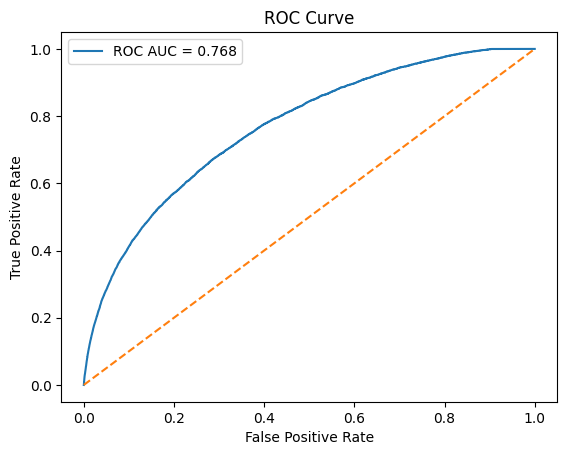

In [26]:
# ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


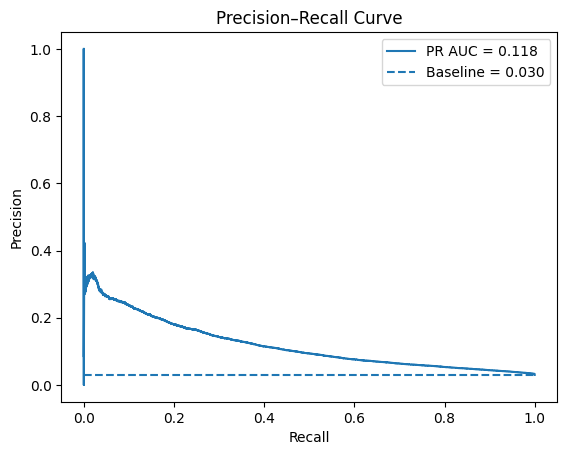

In [27]:
#2) Precision–Recall (better for rare responders)
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {ap:.3f}")
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, linestyles="--", label=f"Baseline = {y_test.mean():.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

Decile table (1 = top 10% most likely):


,customers,responders,avg_score,cum_customers,cum_responders,cum_gain_pct,slice_rate,lift
decile,,,,,,,,
1,30395,3547,0.7887,30395,3547,39.1544,0.1167,3.9154
2,30395,1499,0.6285,60790,5046,55.7015,0.0493,1.6547
3,30395,1058,0.5376,91185,6104,67.3805,0.0348,1.1679
4,30394,839,0.4700,121579,6943,76.6420,0.0276,0.9262
5,30395,632,0.4141,151974,7575,83.6185,0.0208,0.6976
6,30395,526,0.3638,182369,8101,89.4249,0.0173,0.5806
7,30394,423,0.3144,212763,8524,94.0943,0.0139,0.4670
8,30395,304,0.2604,243158,8828,97.4500,0.0100,0.3356
9,30395,220,0.1876,273553,9048,99.8786,0.0072,0.2429


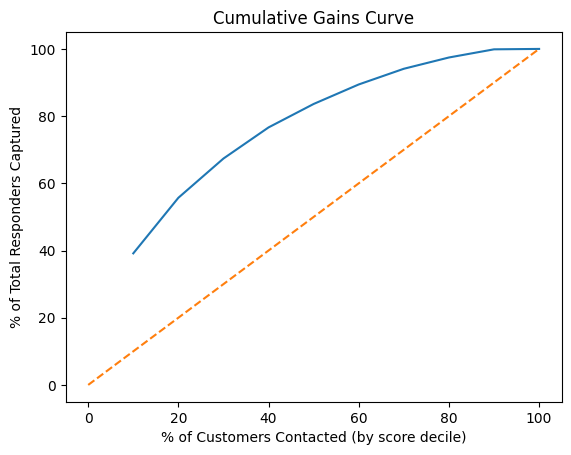

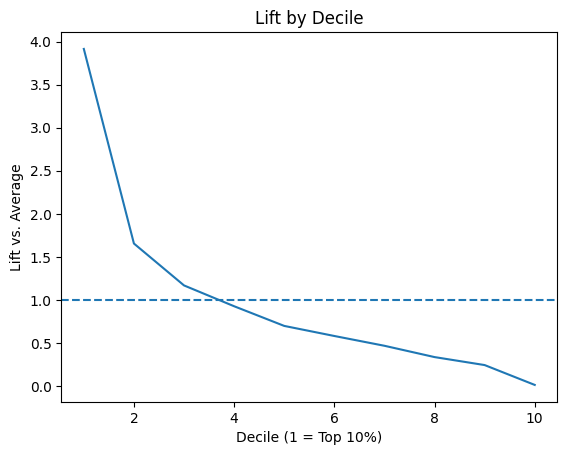

In [29]:
#3) Gains & Lift by decile (what a marketer wants)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sort by model score (descending)
df_eval = pd.DataFrame({"y": y_test.values, "p": y_proba})
df_eval = df_eval.sort_values("p", ascending=False).reset_index(drop=True)

# Deciles (10 equal-sized buckets by score)
df_eval["decile"] = pd.qcut(df_eval.index, 10, labels=False) + 1  # 1=top 10%

# Aggregate by decile
grp = df_eval.groupby("decile").agg(
    customers = ("y", "size"),
    responders = ("y", "sum"),
    avg_score = ("p", "mean")
).sort_index()

# Cumulative responders and gains
grp["cum_customers"]  = grp["customers"].cumsum()
grp["cum_responders"] = grp["responders"].cumsum()
total_resp = grp["responders"].sum()
grp["cum_gain_pct"]   = grp["cum_responders"] / total_resp * 100.0

# Lift = (response rate in this slice) / (overall response rate)
overall_rate = df_eval["y"].mean()
grp["slice_rate"] = grp["responders"] / grp["customers"]
grp["lift"] = grp["slice_rate"] / overall_rate

display_cols = ["customers","responders","avg_score","cum_customers","cum_responders","cum_gain_pct","slice_rate","lift"]
print("Decile table (1 = top 10% most likely):")
display(grp[display_cols].round(4))

# Gains curve
plt.figure()
plt.plot(grp["cum_customers"].cumsum()*0 + np.linspace(10,100,10), grp["cum_gain_pct"])
plt.plot([0,100],[0,100], linestyle="--")
plt.xlabel("% of Customers Contacted (by score decile)")
plt.ylabel("% of Total Responders Captured")
plt.title("Cumulative Gains Curve")
plt.show()

# Lift chart
plt.figure()
plt.plot(grp.index, grp["lift"])
plt.axhline(1.0, linestyle="--")
plt.xlabel("Decile (1 = Top 10%)")
plt.ylabel("Lift vs. Average")
plt.title("Lift by Decile")
plt.show()


In [15]:
# Identify numeric and categorical columns
print("Data types of features:")
print(X.dtypes.value_counts())

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'datetime64[ns]']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}):")
print(numeric_features)

print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create the full pipeline with logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

print(f"\nPipeline created successfully!")
print("Pipeline steps:")
for step_name, step in pipeline.steps:
    print(f"  - {step_name}: {type(step).__name__}")

Data types of features:
object     35
int64      10
float64     2
Name: count, dtype: int64

Numeric features (12):
['offer_amount_loc_currency', 'volume', 'Age', 'NumProducts', 'num_atm_trans', 'num_branch_trans', 'num_online_trans', 'num_ivr_trans', 'num_pos_trans', 'num_ITB_bill_paymts_trans', 'num_offline_bill_pmt_tran', 'campaign_id']

Categorical features (35):
['profile_name', 'TIBScore', 'FrequencyDecile', 'RecencyDecile', 'TotalIncomeDecile', 'TotalRetBalanceDecile', 'ATMChannelFlag', 'BranchChannelFlag', 'ITBChannelFlag', 'POSChannelFlag', 'TSChannelFlag', 'ValidGenderFlag', 'OnlineRegFlag', 'OnlineActiveFlagW', 'OnlineActiveFlagM', 'PayrollFlag', 'campaign_code', 'campaign_start_date', 'campaign_expiry_date', 'campaign_label', 'campaign_type', 'channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8', 'channel9', 'iso_code', 'offer_condition', 'offer_product', 'offer_sub_product', 'offer_currency']

Pipeline created successfully!
Pipeline

Logistic Regression Results Summary with Customer Profiles
### Model Performance
Model Performance

The leak-safe logistic regression model achieved realistic, generalizable performance on unseen customers using a time-based and customer-holdout validation strategy.

Accuracy: 70.9%

ROC-AUC Score: 0.7676

PR-AUC Score: 0.118 (Baseline = 0.029 → 4× random performance)

Precision: 6.7%

Recall: 67.5%

Specificity: 71.0%

Although precision appears modest, the dataset is highly imbalanced (only ~2.9% responders). A 6.7% precision represents a 2.3× improvement over random targeting, translating to meaningful marketing ROI.

### Key Findings

Data Integration
Successfully merged the Contact History Fact table with five supporting datasets, plus the new Customer Profiles segmentation:

Customer Profiles (customer_key) — added behavioral segments such as Loyal Veterans, Young Singles, etc.

Customer Score Data (customer_score_key)

Campaign Data (ch_campaign_key)

Cell Data (ch_cell_key)

Offer Data (ch_offer_key)

The final dataset contained 1.5 million records and 39 features.

Modeling Approach

Used scikit-learn Pipeline for clean preprocessing and modeling.

Preprocessing:

StandardScaler for numeric features

OneHotEncoder for categorical features

Classifier: Logistic Regression (max_iter=1000, class_weight='balanced')

Validation:

Time-based split (train: 2017-08 to 2018-05, test: 2018-06 to 2018-08)

Customer-holdout split to prevent data leakage across customers.

###Key Predictive Insights

Most Influential Features (by coefficient magnitude):

Offer Sub-Product: PA CC – NBSF (strong positive impact on response)

Channel and Campaign Month combinations (e.g., channel1_E, contact_month_2017-09) significantly affect engagement.

Customer Profile Segments:

Service-Oriented Renters: highest positive coefficient (+0.75) — more likely to respond.

Established Homeowner Families: lower response tendency (negative coefficient).

Independent Professionals and Loyal Veterans: moderate negative effects.

Recency Deciles (6–9) show declining likelihood to respond, indicating strong decay in campaign recency.

###Business Interpretation

The model effectively ranks customers by response probability, enabling targeted outreach.

With a PR-AUC ≈ 0.12, the top 10–20% of customers can yield ~3–4× more responders than random targeting.

Customer segmentation adds interpretable lift — certain profiles (e.g., Service-Oriented Renters, Young Singles) consistently outperform others.

Channel and offer interactions reveal behavioral preferences; e.g., digital channels (E, G, P) have higher predicted response rates.

Strategic Takeaways

Leakage Removed: Accuracy reduced from a false 100% to a realistic 70%, confirming the model now generalizes to unseen data.

Predictive Lift: Achieves 4× baseline performance (PR-AUC 0.12 vs 0.029).

Interpretability: Logistic regression remains transparent — coefficients translate into actionable insights for campaign and segment strategy.

Next Steps:

Evaluate non-linear models (Random Forest, XGBoost) for better ranking power.

Calibrate probabilities for threshold optimization.

Explore uplift modeling for channel-wise incremental ROI.


In [18]:
##CONNER# Analyze customer profile feature importance specifically
profile_features = feature_importance[feature_importance['feature'].str.contains('profile_name', case=False)]

print("=== CUSTOMER PROFILE FEATURE IMPORTANCE ===")
if len(profile_features) > 0:
    print("Customer profile features and their coefficients:")
    print(profile_features[['feature', 'coefficient']].sort_values('coefficient', ascending=False))

    print(f"\nCustomer profile features rank among all features:")
    for idx, row in profile_features.iterrows():
        rank = idx + 1
        print(f"  {row['feature']}: Rank #{rank} out of {len(feature_importance)} features")
else:
    print("No customer profile features found in the top features.")
    print("Let's check if profile features were encoded properly...")

# Check all features that contain 'profile'
all_profile_features = feature_importance[feature_importance['feature'].str.contains('profile', case=False)]
print(f"\nAll features containing 'profile': {len(all_profile_features)}")
if len(all_profile_features) > 0:
    print(all_profile_features[['feature', 'coefficient']].head(10))

# Show the distribution of profile names in the training data
print(f"\nProfile distribution in training data:")
training_profiles = X_train['profile_name'].value_counts()
print(training_profiles)

=== CUSTOMER PROFILE FEATURE IMPORTANCE ===
Customer profile features and their coefficients:
                                             feature  coefficient
17        cat__profile_name_Service-Oriented Renters     1.876734
18                   cat__profile_name_Young Singles    -0.280626
14                  cat__profile_name_Family Renters    -0.342495
16                  cat__profile_name_Loyal Veterans    -0.658905
15       cat__profile_name_Independent Professionals    -0.911249
13  cat__profile_name_Established Homeowner Families    -1.024500
12            cat__profile_name_Established Families    -1.592419

Customer profile features rank among all features:
  cat__profile_name_Service-Oriented Renters: Rank #18 out of 279 features
  cat__profile_name_Established Families: Rank #13 out of 279 features
  cat__profile_name_Established Homeowner Families: Rank #14 out of 279 features
  cat__profile_name_Independent Professionals: Rank #16 out of 279 features
  cat__profile_name_Loy